## Creating a logistic regression model in Python!

In [1]:
# Reference: https://github.com/susanli2016/Machine-Learning-with-Python/blob/master/Logistic%20Regression%20balanced.ipynb

### Import necessary libraries:

In [2]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt

plt.rc("font", size=14) 

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

#from mpl_toolkits.basemap import Basemap


import os
import datetime
import pytz
import re

import peakutils
import statsmodels.api as sm

import requests

#Read data from a local csv file:

##Will change this to scrape files from the Smartfin.org website later.
#data = pd.read_csv('Motion_13735.CSV', header=0)   
#data = data.dropna()

#Print out the column headings:
#print(data.shape)
#print(list(data.columns))

In [3]:
from smartfin_web_scraper import Ride
ride = Ride('15692', data='motion')
df = ride.get_ride_dataframe()
df.head(10)

fetching ride from: https://surf.smartfin.org/ride/15692
fetching motion data from: https://surf.smartfin.org/media/201811/google_105349665704999793400_0006667E229D_181109191556_Motion.CSV


,Time,IMU A1,IMU A2,IMU A3,IMU G1,IMU G2,IMU G3,IMU M1,IMU M2,IMU M3,TimeDelta
UTC,,,,,,,,,,,
2018-11-09 19:16:03.789000+00:00,1.414743e+09,493.0,48.0,110.0,75.0,-124.0,-86.0,-309.0,209.0,39.0,0.0
2018-11-09 19:16:04.053000+00:00,1.414743e+09,513.0,89.0,62.0,34.0,-36.0,-92.0,-320.0,194.0,38.0,252.5
2018-11-09 19:16:04.284000+00:00,1.414743e+09,494.0,92.0,80.0,69.0,-63.0,-42.0,-329.0,189.0,49.0,501.5
2018-11-09 19:16:04.548000+00:00,1.414744e+09,421.0,205.0,-104.0,192.0,-92.0,-37.0,-330.0,180.0,64.0,753.5
2018-11-09 19:16:04.812000+00:00,1.414744e+09,534.0,306.0,-32.0,-421.0,-233.0,-229.0,-325.0,161.0,97.0,1003.5
2018-11-09 19:16:05.043000+00:00,1.414744e+09,455.0,149.0,-102.0,-355.0,-376.0,-397.0,-337.0,117.0,151.0,1253.5
2018-11-09 19:16:05.307000+00:00,1.414744e+09,474.0,342.0,-219.0,-234.0,-527.0,-465.0,-311.0,25.0,217.0,1504.5
2018-11-09 19:16:05.571000+00:00,1.414745e+09,363.0,323.0,-131.0,60.0,-662.0,-305.0,-238.0,-8.0,272.0,1755.5
2018-11-09 19:16:05.802000+00:00,1.414745e+09,-21.0,510.0,-447.0,78.0,-643.0,-153.0,-159.0,-21.0,321.0,2006.5


In [74]:
ride.get_ride_timeframe()

('09/11/2018 19:16:03', '09/11/2018 20:38:15')

## Footage sync code written by Alina:

In [207]:
#Footage sync code written by Alina: (Miulti-Column)

import time

#simple method: only walking, paddling, floating, surfing
#complex method: columns created based on footage file labels
def label_data( footage_file = '../Labelled_Footage/Footage3.txt', labelling_method = 'simple', sync_threshold = 20000 ):
    
    # calculate sync_buf which will be used to merge the footage data and the imu data    
    #First, perform sync
    sync_buf = 0
    with open(footage_file) as file:
        # for each reading in footage file: 
        for line in file:     
            
            # get labeled time and format it into a time structure object            
            labelled_time = line.split(None, 2) 
#             print('labelled_time: ', labelled_time)
            try:
                cur_time = time.strptime(labelled_time[0], '%M:%S')
#                 print('curr_time: ', cur_time)

            except:
                continue
            
            #             
            labelled_time[1] = labelled_time[1].rstrip()
            if labelled_time[1].lower() == 'sync': #Assumption that first word in sync line is "sync"
                sync_time = cur_time.tm_min * 60 * 1000 + cur_time.tm_sec * 1000
                print(f'sync_time: {sync_time}')
                index = 0
                start = 0
                end = 0
                #Syncing occurs when IMU A2 data is negative for a longer period than the provided threshold
                #Default is 20 seconds
                for data in df['IMU A2']:
#                     print(data)
                    # 
                    if data < 0 and start == 0:
                        start = df['TimeDelta'][index]
#                         print('start: ', start)
                    elif data > 0 and start != 0:
                        end = df['TimeDelta'][index]
#                         print('end: ', end)
                        
                        # calculate the buffer between the time of sync start and the sync time                        
                        if end - start > sync_threshold:
                            sync_buf = start - sync_time
                            
                            break
                        start = 0
                    index += 1

    accepted_labels = set()
    
    print(f'sync_buf: {sync_buf}')
    
    
    # SYNC DONE NOW START LABELING
    
    
    # if in simple label mode, create 4 classifications of footage data, if not, 
    # then just use the labels in the footage file 
    if labelling_method == 'simple':
        accepted_labels = {'WALKING', 'PADDLING', 'FLOATING', 'SURFING'}
        
        # add label columns and fill with default 0        
        #Create new DataFrame containing label info
        label_frame = pd.DataFrame(0, index = df.index, columns = accepted_labels)
        for label in accepted_labels:
            print(f'label: {label}')
            label_frame[label] = [0] * len(df['Time'])
    
    
    # use the calulated sync_buf to alignt he footage data with the imu data
    #Convention of labelled footage text: "MINUTE:SECOND LABEL"
    elapsed_time = 0
    cur_label = ''
    buffer = 0
    with open(footage_file) as file:
        for line in file:
            
            # if simple method, just look for first word
            # labelled time is a tuple containing the time of event and the type of event
            if labelling_method == 'simple':
                labelled_time = line.split(None, 2) #simple categorizes on a one-word basis
            else:
                labelled_time = line.split(None, 1) #complex requires the entire label\
                    
            
            #If the first word is not a properly formatted time, the line cannot be read
            try:
                # format time in time structure
                cur_time = time.strptime(labelled_time[0], '%M:%S')
                # calculate the current time in ms using sync_buf                
                cur_timeMS = cur_time.tm_min * 60 * 1000 + cur_time.tm_sec * 1000 + sync_buf
            except:
                continue
                
            labelled_time[1] = labelled_time[1].rstrip() #Remove potential newline


                
            #Check for end of video and modify buffer accordingly
            # assign the time of the 'end of video' to buffer
            if labelled_time[1].lower() == 'end of video': #Assumption that label end video with "end of video"
                buffer += cur_timeMS
                


                
            #----Complex "mode" below: --------
                
            #Modify accepted labels list if reading a new label and in complex mode
            elif labelling_method == 'complex' and (labelled_time[1].upper() not in accepted_labels):
                accepted_labels.add(labelled_time[1].upper())
                if not cur_label:
                    label_frame = pd.DataFrame(0, index = df.index, columns = accepted_labels)
                label_frame[labelled_time[1].upper()] = [0] * len(df['Time'])
                
            if labelled_time[1].upper() in accepted_labels:
                print(df['TimeDelta'][elapsed_time] < cur_timeMS + buffer)
                # when cur_label is unchanged, fill keep filling rows with same label
                while (elapsed_time < len(df['Time']) and
                      (np.isnan(df['TimeDelta'][elapsed_time]) or
                       df['TimeDelta'][elapsed_time] < cur_timeMS + buffer)):
                    
                    # mark label in dataframe
                    if cur_label != '':
                        label_frame[cur_label][elapsed_time] = 1
                        print('')
                    
                    # increment to fill the next row
                    elapsed_time += 1
                
                # change label 
                if labelled_time[1].upper() != 'end of video':
#                     print('labelled_time: ', labelled_time)
#                     print(f'elapsed_time: {elapsed_time}')
                    cur_label = labelled_time[1].upper()
                    print(f'cur_label: {cur_label}')



    # concatinate time labels with their corresponsing measurements by time index    
    labelled = pd.concat([df, label_frame], axis = 1)


    return labelled

pd.options.display.max_rows = 5000
pd.options.display.max_columns = 5000

In [208]:
motion_df_simple = label_data('../Labelled_Footage/Footage3.txt')
motion_df_simple.SURFING.sum()

sync_time: 36000
sync_buf: 23763.5
label: FLOATING
label: PADDLING
label: SURFING
label: WALKING
True
cur_label: WALKING
True





















cur_label: PADDLING
True




















































































cur_label: WALKING
True
































































































cur_label: PADDLING
True
































































































































































cur_label: FLOATING
True





























































































cur_label: FLOATING
True



































































































































































































cur_label: PADDLING
True






































cur_label: SURFING
True
















cur_label: PADDLING
False
cur_label: FLOATING
False
cur_label: PADDLING
False
cur_label: FLOATING
False
cur_label: PADDLING
False
cur_label: SURFING
False
cur_label: WALKING
False
cur_label: PADDLING
False
cur_label: FLOATING
False
cur_label: PADDLING
False
cur_label: SURFING
False
cur_label: WALKING
False
cur_label: PADDLING
True


























































cur_label: FLOATING
False
cur_label: PADDLING
False
cur_label: FLOATING
False
cur_label: PADDLING
False
cur_label: FLOATING
False
cur_label: FLOATING
False
cur_label: PADDLING
False
cur_label: FLOATING
False
cur_label: PADDLING
False
cur_label: SURFING
False
cur_label: WALKING
False
cur_label: PADDLING
False
cur_label: SURFING
False
cur_label: WALKING
False
cur_label: WALKING
False
cur_label: PADDLING
False
cur_label: FLOATING
False
cur_label: PADDLING
False
cur_label: PADDLING
False
cur_label: WALKING
False
cur_label: PADDLING
False
cur_label: FLOATING
False
cur_label: PADDLING
False
cur_label: SURFIN

148

In [193]:
motion_df_complex = label_data('../Labelled_Footage/Footage3.txt', 'complex')
motion_df_complex.SURFING.sum()

sync_time: 36000
sync_buf: 23763.5
True
cur_label: SYNC
True
cur_label: FLIP BOARD RIGHT SIDE UP
True
cur_label: WALKING IN WATER
True
cur_label: PUSH-OFF
True
cur_label: PADDLING INTO WAVES
True
cur_label: WALKING IN WATER
True
cur_label: PUSH-OFF
True
cur_label: PADDLING INTO WAVES
True
cur_label: SIT-UP
True
cur_label: FLOATING
True
cur_label: TURNING TO SURFER'S LEFT
True
cur_label: FLOATING
True
cur_label: LAY-DOWN
True
cur_label: PADDLING FOR A WAVE
True
cur_label: POP-UP
True
cur_label: SURFING
True
cur_label: STEP-OFF
True
cur_label: WALKING IN WATER
True
cur_label: PUSH-OFF
True
cur_label: PADDLING INTO WAVES
True
cur_label: SIT-UP
True
cur_label: FLOATING
True
cur_label: TURNING TO SURFER'S RIGHT
True
cur_label: LAY-DOWN
True
cur_label: PADDLING FOR A WAVE
True
cur_label: POP-UP
True
cur_label: SIT-BACK
True
cur_label: TURNING TO SURFER'S LEFT
True
cur_label: WALKING IN WATER
True
cur_label: PUSH-OFF
True
cur_label: PADDLING INTO WAVES
True
cur_label: SIT-UP
True
cur_label: F

cur_label: TURNING TO SURFER'S RIGHT
True
cur_label: LAY-DOWN
True
cur_label: PADDLING FOR A WAVE
True
cur_label: SIT-BACK
True
cur_label: TURNING TO SURFER'S LEFT
True
cur_label: FLOATING
True
cur_label: TURNING TO SURFER'S RIGHT
True
cur_label: LAY-DOWN
True
cur_label: PADDLING FOR A WAVE
True
cur_label: SIT-BACK
True
cur_label: FLOATING
True
cur_label: TURNING TO SURFER'S LEFT
True
cur_label: LAY-DOWN
True
cur_label: FLOATING
True
cur_label: PADDLING INTO WAVES
True
cur_label: SIT-UP
True
cur_label: FLOATING
True
cur_label: TURNING TO SURFER'S RIGHT
True
cur_label: LAY-DOWN
True
cur_label: PADDLING FOR A WAVE
True
cur_label: POP-UP
True
cur_label: SURFING
True
cur_label: STEP-OFF
True
cur_label: OFF-BOARD
True
cur_label: PULL-BACK LEASH
True
cur_label: WALKING IN WATER
True
cur_label: PUSH-OFF
True
cur_label: PADDLING FOR A WAVE
True
cur_label: POP-UP
True
cur_label: SURFING
True
cur_label: STEP-OFF
True
cur_label: PULL-BACK LEASH
True
cur_label: WALKING IN WATER
True
cur_label: TUR

21645

## Split up surfing data into individual waves

In [264]:
waves = []
times = []
wave_end_indices = []
wave_start_indices = []
wave_seen = False
index = 0
wave_count = 0
for row in motion_df_complex.iterrows():

    # if surfing stays 0 
    if (row[1]['SURFING'] == 0 and not wave_seen):
        wave_seen = False
        continue
        
    # if surfing is 1
    elif (row[1]['SURFING'] == 1):
        if (not wave_seen): 
            wave_seen = True
            wave_count += 1
            wave_start_indices.append(index)
    
        index += 1
        waves.append(row[1]['IMU A2'])
        times.append(row[1]['Time'])
        
    # if surfing returns from 1 to 0
    elif (row[1]['SURFING'] == 0 and wave_seen):
        wave_seen = False
        wave_end_indices.append(index - 1)


        

len(waves     ) 


182

In [265]:
times = [time / 1000 for time in times]
times

[1414994.745,
 1414994.987,
 1414995.237,
 1414995.49,
 1414995.739,
 1414995.991,
 1414996.241,
 1414996.493,
 1414996.743,
 1414996.993,
 1414997.244,
 1414997.495,
 1414997.745,
 1414997.996,
 1414998.246,
 1414998.487,
 1414998.737,
 1414998.989,
 1414999.239,
 1414999.489,
 1414999.739,
 1414999.991,
 1415000.241,
 1415000.495,
 1415000.745,
 1415000.996,
 1415001.239,
 1415001.489,
 1415001.742,
 1415001.993,
 1415002.243,
 1415002.493,
 1415219.795,
 1415220.046,
 1415220.287,
 1415220.537,
 1415415.887,
 1415416.138,
 1415416.389,
 1415416.641,
 1415416.8875,
 1415417.143,
 1415417.393,
 1415417.643,
 1415691.788,
 1415692.038,
 1415692.289,
 1415692.54,
 1415692.792,
 1415693.041,
 1415693.291,
 1415693.541,
 1415693.789,
 1415694.039,
 1415694.289,
 1415694.541,
 1415694.791,
 1415695.041,
 1415695.292,
 1415695.543,
 1415695.794,
 1415696.045,
 1415696.295,
 1415696.546,
 1415696.796,
 1415697.037,
 1415697.287,
 1415697.537,
 1415697.787,
 1415698.039,
 1415698.288,
 141569

In [266]:
wave_end_indices

[31, 35, 43, 75, 95, 111, 121, 146, 161, 181]

In [267]:
wave_start_indices

[0, 32, 36, 44, 76, 96, 112, 122, 147, 162]

### Convert the Raw IMU data values to real units:

In [268]:
#correct IMU data
for i in range(len(waves)):
    waves[i] *= 0.019141
  
waves

[10.71896,
 9.053692999999999,
 8.977129,
 7.962655999999999,
 11.733433,
 8.977129,
 7.08217,
 8.824000999999999,
 10.642396,
 7.541554,
 12.690482999999999,
 2.4691889999999996,
 15.274517999999999,
 10.546691,
 12.192817,
 11.886560999999999,
 9.532217999999999,
 8.881423999999999,
 9.225961999999999,
 7.005605999999999,
 10.14473,
 9.321667,
 8.020078999999999,
 9.130256999999999,
 9.723628,
 7.158733999999999,
 8.80486,
 10.259576,
 8.996269999999999,
 10.546691,
 9.608782,
 9.417371999999999,
 9.225961999999999,
 9.5705,
 9.532217999999999,
 11.561164,
 5.876287,
 9.37909,
 7.943515,
 5.780582,
 2.1629329999999998,
 15.829607,
 9.781051,
 9.264244,
 9.436513,
 7.120451999999999,
 5.340338999999999,
 8.80486,
 10.508408999999999,
 9.264244,
 12.403367999999999,
 7.905232999999999,
 10.14473,
 7.790386999999999,
 8.441180999999998,
 8.900564999999999,
 9.072833999999999,
 5.531749,
 3.7324949999999997,
 -1.0336139999999998,
 11.388895,
 0.9187679999999999,
 9.321667,
 10.6232549999

## Perform double integral analysis on each wave

In [269]:
from scipy import stats
from scipy import constants
from scipy import signal #added
from scipy.interpolate import CubicSpline
from scipy.interpolate import interp1d
from scipy.integrate import simps
from scipy.integrate import cumtrapz
from scipy import integrate


# detrend wave accelerations
d_waves = signal.detrend(waves)
f_s = 5.0 #sampling frequency



In [270]:
## Butter Filters for Bandpass:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_lfilter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = signal.lfilter(b, a, data)
    return y

def butter_bandpass_filtfilt(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y



##Butter Filters for Highpass:
def butter_highpass(highcut, fs, order=5):
    nyq = 0.5 * fs
    high = highcut / nyq
    b, a = signal.butter(order, high, btype='high')
    return b, a

def butter_highpass_lfilter(data, highcut, fs, order=5):
    b, a = butter_lowpass(highcut, fs, order=order)
    y = signal.lfilter(b, a, data)
    return y



##Butter Filters for Lowpass:
def butter_lowpass(lowcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    b, a = signal.butter(order, low, btype='low')
    return b, a

def butter_lowpass_lfilter(data, lowcut, fs, order=5):
    b, a = butter_lowpass(lowcut, fs, order=order)
    y = signal.lfilter(b, a, data)
    return y





NEW WAVE
butter lfilter length:  31
v_integral:  [ 0.          0.02159235  0.08553541  0.17723668  0.21875326  0.15931954
  0.06629634  0.03369765  0.02011339 -0.08354406 -0.23923908 -0.28641017
 -0.19259097 -0.10242242 -0.07358453  0.06485283  0.45547934  0.89924376
  1.02509313  0.69004342  0.08490169 -0.48130738 -0.81027755 -0.90910901
 -0.8927344  -0.87547955 -0.88021014 -0.87089338 -0.81656453 -0.68686561
 -0.44946957]
length 31
detrend_v_integral:  [-0.31010535 -0.25784243 -0.16322883 -0.040857    0.03133014  0.00256699
 -0.05978566 -0.06171379 -0.04462749 -0.11761439 -0.24263885 -0.25913938
 -0.13464963 -0.01381052  0.04569793  0.21480585  0.63610292  1.1105379
  1.26705782  0.96267867  0.38820749 -0.14733102 -0.44563063 -0.51379153
 -0.46674636 -0.41882095 -0.39288099 -0.35289367 -0.26789426 -0.10752479
  0.16054181]
disp_integral [ 0.         -0.0043438  -0.01938462 -0.04777622 -0.07643065 -0.08335425
 -0.05691926 -0.01064611  0.02766742  0.04282849  0.04034092  0.03295164
  0

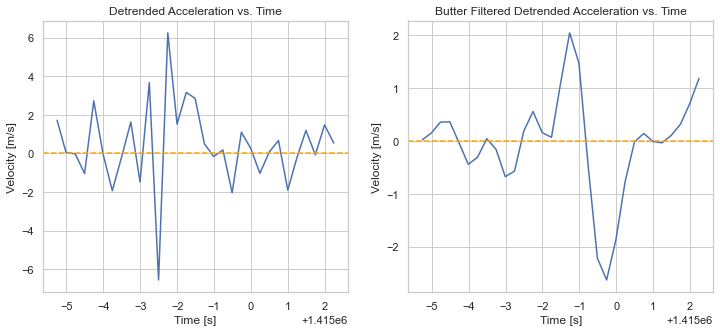

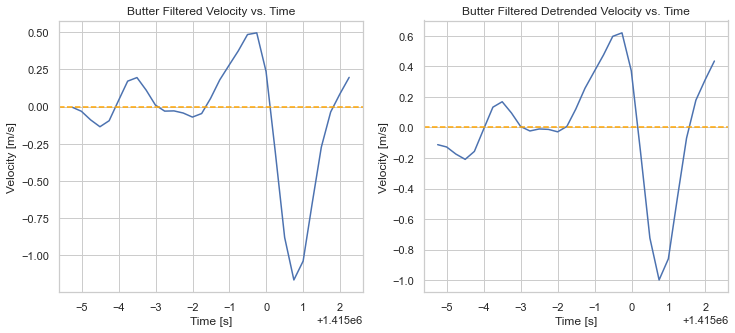

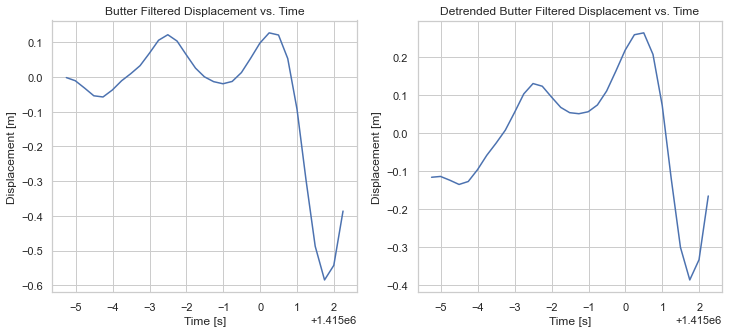

NEW WAVE
butter lfilter length:  3
v_integral:  [0.         0.00284445 0.01500149]
length 3
detrend_v_integral:  [ 0.0015521  -0.00310419  0.0015521 ]
disp_integral [0.00000000e+00 1.42268140e-05 3.34735422e-05]
length 3


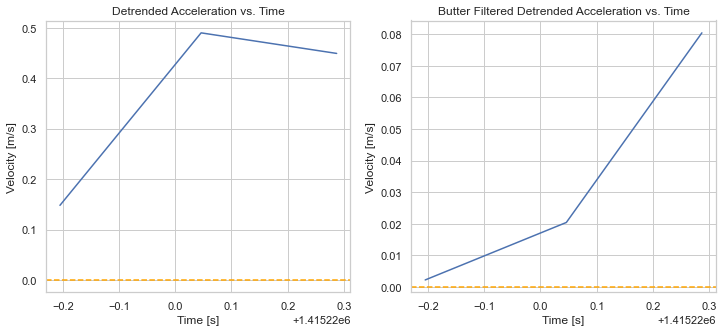

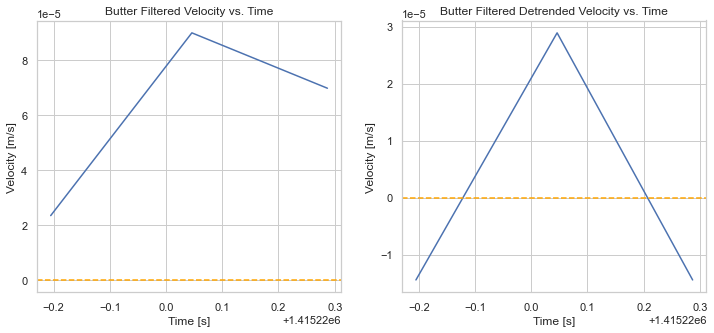

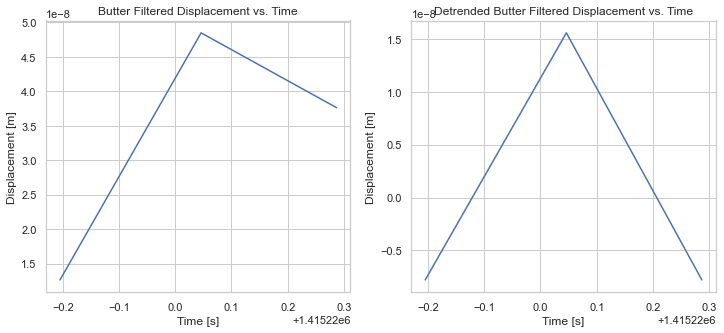

NEW WAVE
butter lfilter length:  7
v_integral:  [ 0.         -0.04105777 -0.15810253 -0.33974394 -0.51002057 -0.66044913
 -0.79845723]
length 7
detrend_v_integral:  [-0.06881759  0.03248437  0.05779933  0.01851765 -0.00939924 -0.01746807
 -0.01311644]
disp_integral [ 0.         -0.00082993 -0.00284102 -0.00451559 -0.00240607  0.00446433
  0.01067332]
length 7


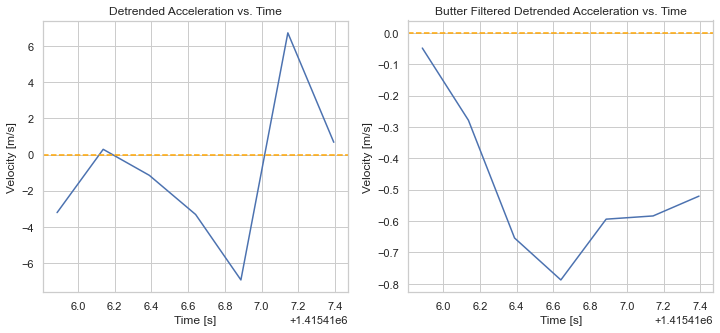

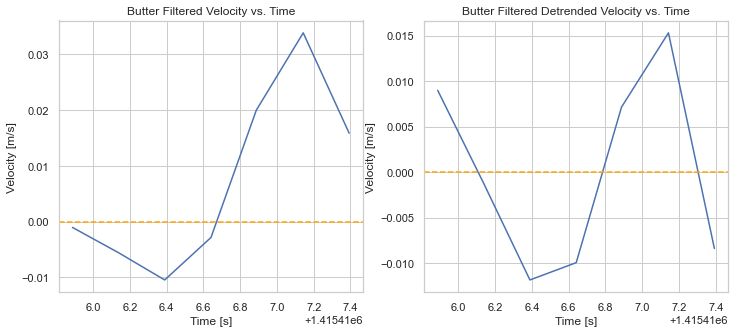

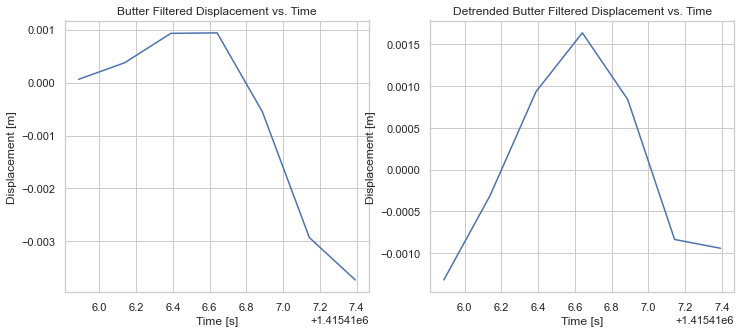

NEW WAVE
butter lfilter length:  31
v_integral:  [ 0.00000000e+00  4.83914493e-04 -2.03109625e-02 -1.25835836e-01
 -3.63864231e-01 -6.21729767e-01 -6.45022924e-01 -2.82721837e-01
  2.90952069e-01  7.27126330e-01  7.95818050e-01  5.59073378e-01
  2.51117670e-01  4.62736261e-02 -6.00450963e-02 -2.46347966e-01
 -7.22754703e-01 -1.46253295e+00 -2.07138334e+00 -2.10139076e+00
 -1.47184618e+00 -5.09227867e-01  5.11512348e-01  1.32325535e+00
  1.82473371e+00  2.05964025e+00  2.17375367e+00  2.30093194e+00
  2.42723948e+00  2.38394063e+00  2.03396896e+00]
length 31
detrend_v_integral:  [ 0.7747535   0.704222    0.61241171  0.43587143  0.12682763 -0.20205332
 -0.29636188 -0.00507621  0.49758229  0.86274114  0.86041745  0.55265737
  0.17368625 -0.1021732  -0.27950733 -0.53682561 -1.08424775 -1.89504141
 -2.57490721 -2.67593004 -2.11740087 -1.22579797 -0.27607316  0.46465443
  0.89511738  1.05900852  1.10210652  1.15826938  1.21356151  1.09924726
  0.67826018]
disp_integral [ 0.          0.011324

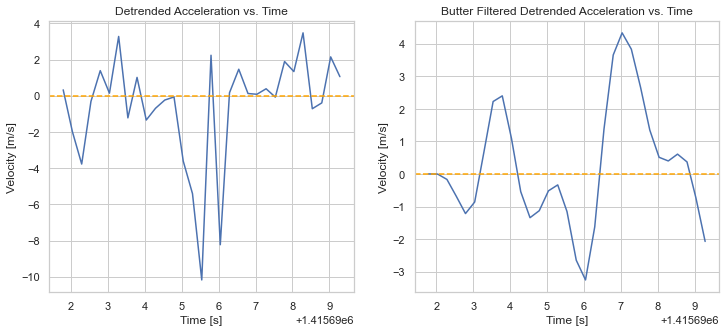

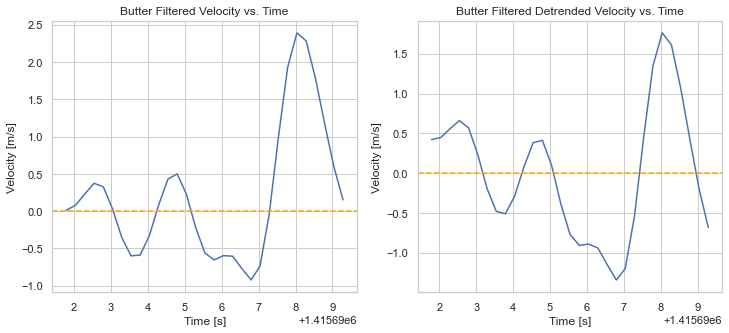

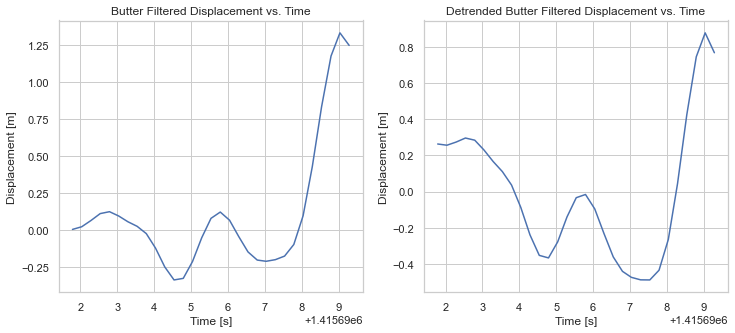

NEW WAVE
butter lfilter length:  19
v_integral:  [ 0.          0.00545226  0.02363219  0.05473634  0.08019399  0.06790943
  0.01103256 -0.05952868 -0.09871092 -0.08452883 -0.02401737  0.05359422
  0.1250305   0.15500721  0.12156426  0.02637246 -0.10947662 -0.25841772
 -0.39049366]
length 19
detrend_v_integral:  [-0.07147912 -0.05632656 -0.02844633  0.01235812  0.04751608  0.04493183
 -0.00224475 -0.06310568 -0.09258762 -0.06870523  0.00150653  0.08881842
  0.16995501  0.20963201  0.18588937  0.10039787 -0.02575091 -0.16499171
 -0.28736734]
disp_integral [ 0.         -0.0008269  -0.00356815 -0.0084234  -0.01308772 -0.01277166
 -0.00519099  0.00644435  0.01465835  0.01363164  0.00352865 -0.00800081
 -0.01258475 -0.00360215  0.01791432  0.04439323  0.06523607  0.07077863
  0.05553058]
length 19


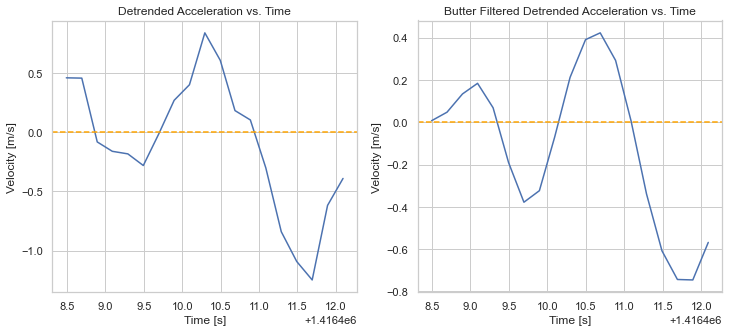

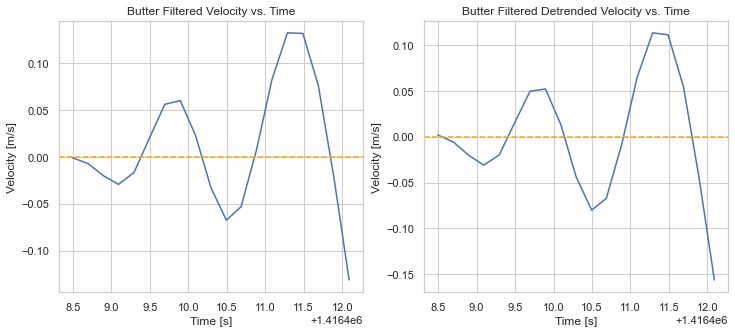

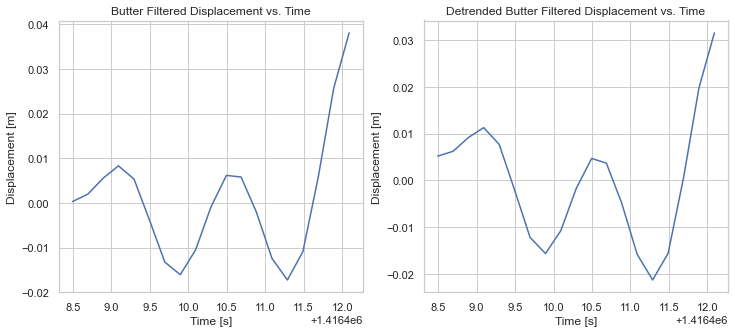

NEW WAVE
butter lfilter length:  15
v_integral:  [ 0.00000000e+00  7.35405891e-03  2.91039976e-02  7.02353373e-02
  1.32436466e-01  2.16790923e-01  2.90061851e-01  2.86757170e-01
  1.66138363e-01 -2.81599859e-04 -1.05158036e-01 -1.36006104e-01
 -1.71213138e-01 -2.54157801e-01 -3.54241634e-01]
length 15
detrend_v_integral:  [-0.19050881 -0.15763273 -0.11036077 -0.04370741  0.04401574  0.15389222
  0.25268517  0.27490251  0.17980573  0.03890779 -0.04044663 -0.04577267
 -0.05545769 -0.11288033 -0.18744214]
disp_integral [ 0.         -0.00276634 -0.01201555 -0.02952659 -0.04772433 -0.05255213
 -0.03484168  0.00512713  0.05399564  0.09853828  0.12584202  0.12454831
  0.09389574  0.04364235 -0.00649872]
length 15


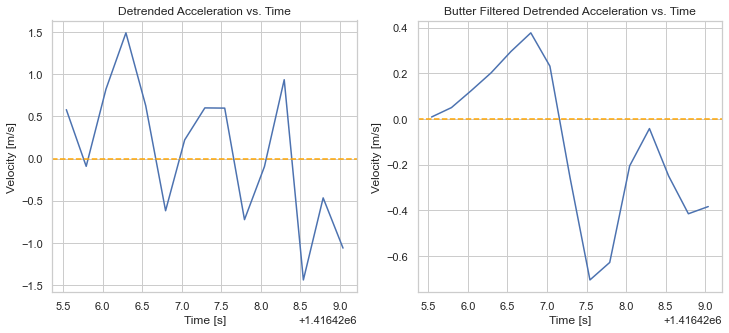

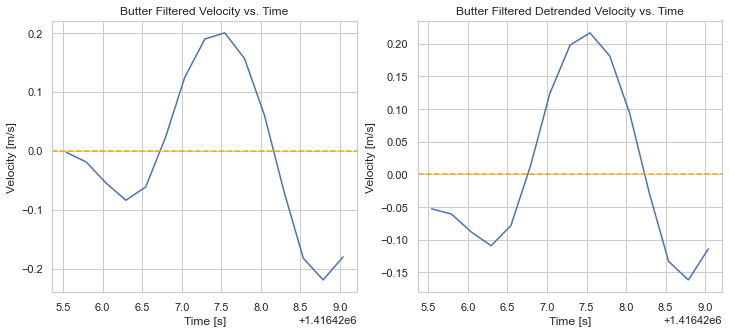

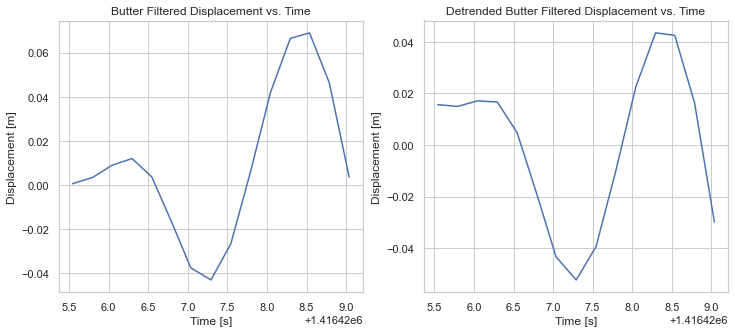

NEW WAVE
butter lfilter length:  9
v_integral:  [ 0.          0.00919162  0.03944543  0.09478092  0.14701152  0.14327008
  0.05416474 -0.08157586 -0.17005226]
length 9
detrend_v_integral:  [-0.08455405 -0.06078603 -0.01595583  0.05395606  0.12076306  0.13159801
  0.05706906 -0.06409514 -0.13799514]
disp_integral [ 0.         -0.00096447 -0.004104   -0.00957786 -0.01379056 -0.01059755
  0.00307639  0.02260182  0.03659796]
length 9


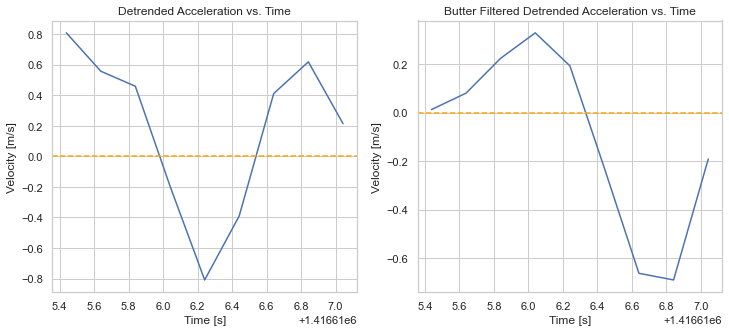

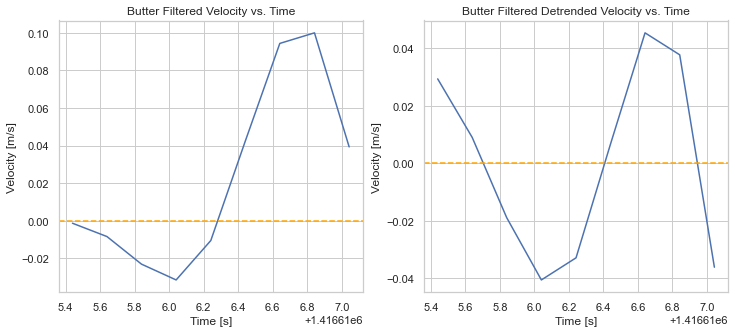

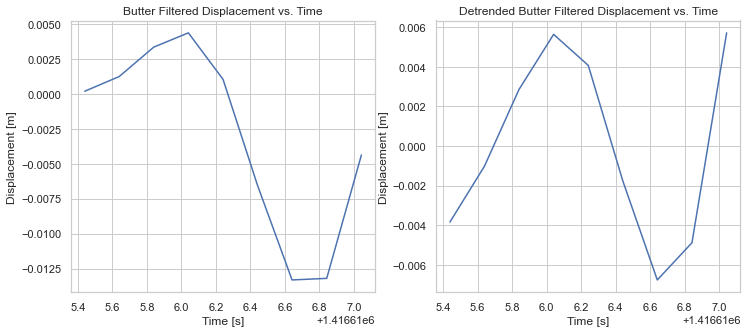

NEW WAVE
butter lfilter length:  24
v_integral:  [ 0.         -0.00096086 -0.00483797 -0.01385872 -0.02829205 -0.0451952
 -0.05626296 -0.04499639  0.00505022  0.08693661  0.16161685  0.18744473
  0.16030008  0.11196878  0.06695856  0.01983394 -0.04711557 -0.10973865
 -0.12149659 -0.06881526  0.0024818   0.0252253  -0.02314874 -0.10527362]
length 24
detrend_v_integral:  [-0.02866507 -0.02770514 -0.02966146 -0.03676143 -0.04927397 -0.06425634
 -0.07340331 -0.06021595 -0.00824855  0.07555862  0.15215966  0.17990833
  0.15468446  0.10827395  0.06518451  0.01998069 -0.04504803 -0.10575033
 -0.11558748 -0.06098537  0.01223248  0.03689678 -0.00955648 -0.08976057]
disp_integral [ 0.         -0.00032249 -0.00149669 -0.00389738 -0.00705222 -0.00988334
 -0.01186161 -0.01347587 -0.01515151 -0.01560325 -0.01154416  0.00057974
  0.02137482  0.04644414  0.0672177   0.0748596   0.06726907  0.04721886
  0.02043406 -0.00846953 -0.0360472  -0.05648383 -0.0641001  -0.05762137]
length 24


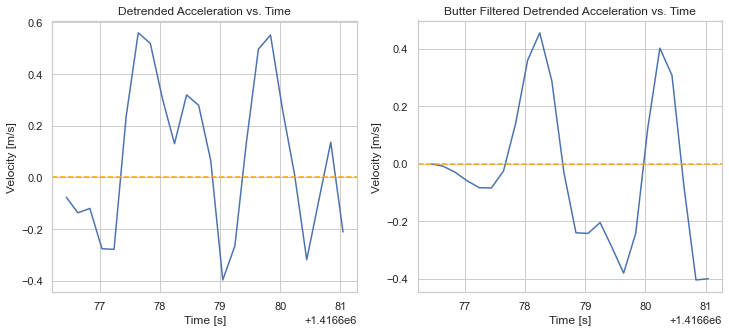

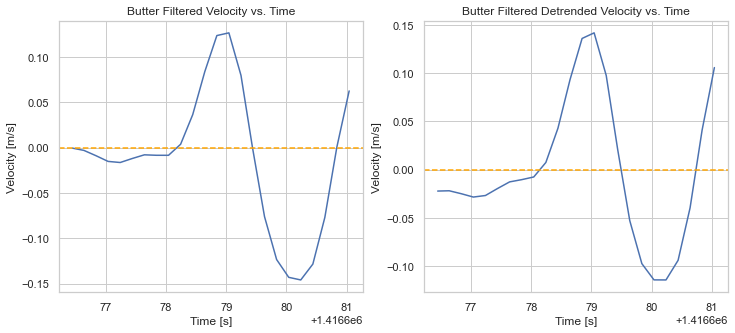

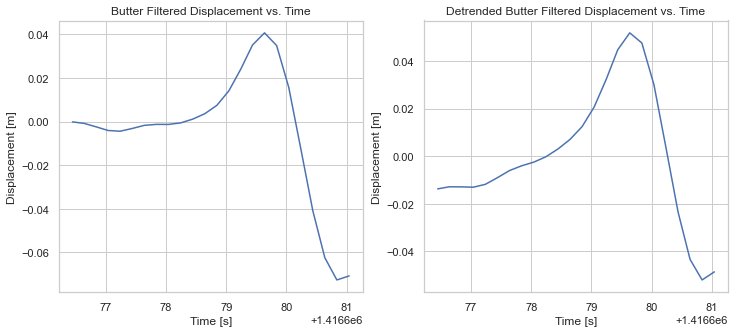

NEW WAVE
butter lfilter length:  14
v_integral:  [ 0.         -0.00083582 -0.0014605   0.00529853  0.03179007  0.07930116
  0.12249581  0.12337228  0.0685762  -0.01722282 -0.09751818 -0.1490817
 -0.16758332 -0.15331727]
length 14
detrend_v_integral:  [-0.07672985 -0.06404476 -0.05114852 -0.03086857  0.00914389  0.07017589
  0.12689146  0.14128885  0.10001369  0.02773558 -0.03903886 -0.07708146
 -0.08206216 -0.05427519]
disp_integral [ 0.         -0.00089307 -0.00390409 -0.0096356  -0.0158696  -0.01818121
 -0.01306249 -0.00034187  0.01746523  0.03567833  0.04841876  0.04951767
  0.03653233  0.01300121]
length 14


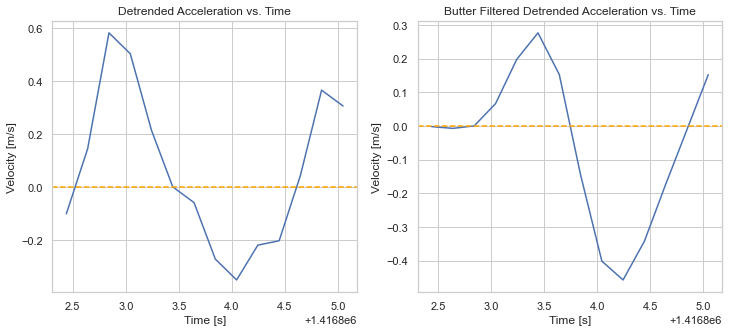

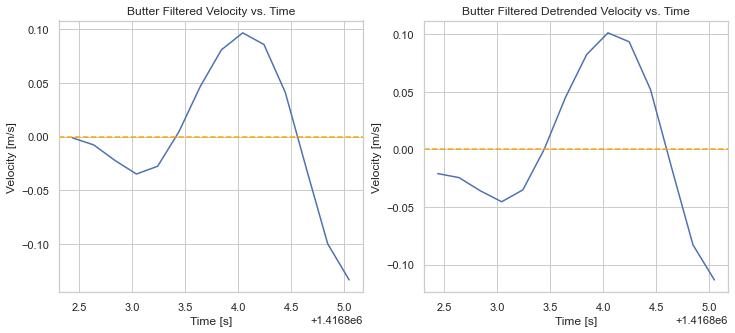

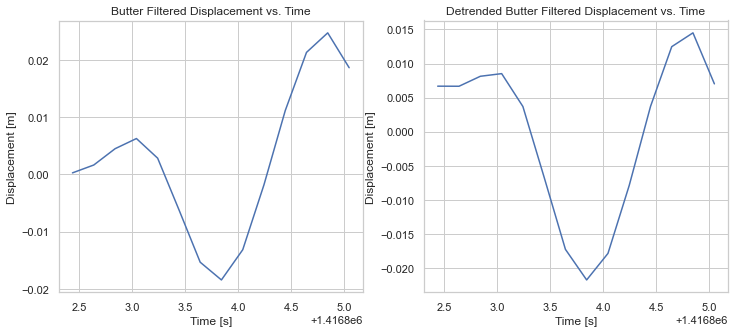

NEW WAVE
butter lfilter length:  19
v_integral:  [ 0.          0.00042848  0.00349574  0.01541692  0.04321004  0.0827406
  0.11017998  0.10026781  0.04815449 -0.0171526  -0.05943029 -0.07102062
 -0.07472168 -0.09091845 -0.11217235 -0.11603882 -0.09669064 -0.07592457
 -0.08073334]
length 19
detrend_v_integral:  [-0.06317127 -0.05343774 -0.04106543 -0.0198392   0.01725896  0.06609457
  0.102839    0.10223188  0.05942362  0.00342158 -0.02955106 -0.03183635
 -0.02623236 -0.03312408 -0.04507293 -0.03963435 -0.01098112  0.01909001
  0.02358628]
disp_integral [ 0.         -0.00074733 -0.00321971 -0.00794012 -0.0130249  -0.0146227
 -0.00997584  0.00125611  0.01601521  0.02988134  0.03771541  0.03571147
  0.02387495  0.00698644 -0.00823158 -0.01800534 -0.02303699 -0.02571531
 -0.02643987]
length 19


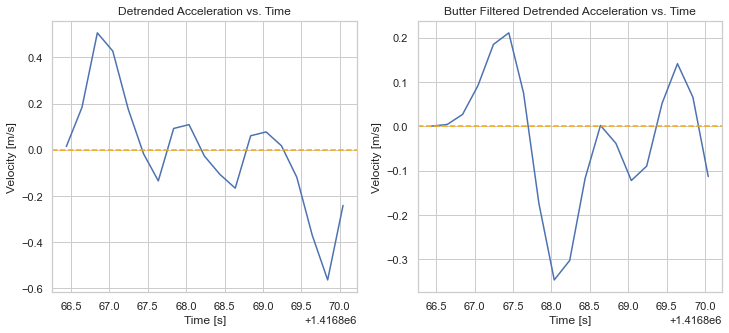

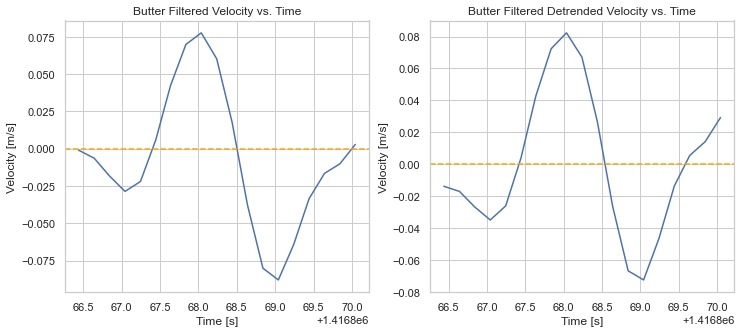

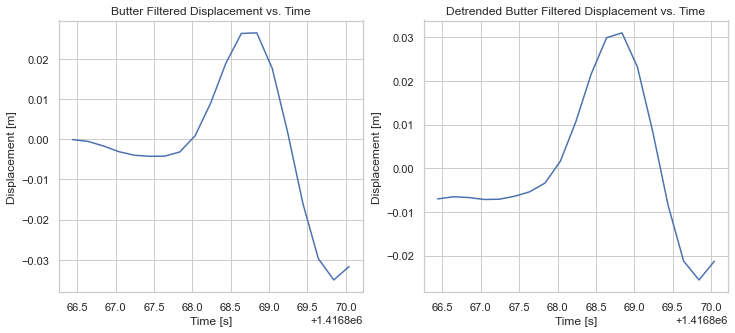

Done.


In [271]:
# Define the sample rate and the Low and High Cutoff frequencies

fs = 5 #redefine the sampling frequency

order=6
lowcut = 0.09
highcut = 1.0

def double_integral_bandpass(time_array, dacc_array, lowcut, highcut, fs, order):
    
    # pass the detrended acceleration array through a lowcut butter bandpass filter
    # cuts 100 datapoints out of the acceleration list 
    butter_lfilter = butter_bandpass_lfilter(dacc_array, lowcut, highcut, fs, order=5)
    print('butter lfilter length: ', len(butter_lfilter))

    # integrate the filter detrended acceleration array
    #First integral is the velocity:
    v_integral = integrate.cumtrapz(x=time_array, y=butter_lfilter, initial=0)
    print('v_integral: ', v_integral)
    print('length', len(v_integral))
    
    # detrend the integral just calculated
    detrend_v_integral = signal.detrend(v_integral)
    print('detrend_v_integral: ', detrend_v_integral)

    # pass the detrended integral through another butter bandpass filter
    v_butter_filter_integral = butter_bandpass_lfilter(detrend_v_integral, lowcut, highcut, fs, order=5)
    
    # detrend that integral
    detrend_v_integral = signal.detrend(v_butter_filter_integral)


    # same thing but integrate the velocity to get displacement
    #Second integral is the displacment:
    disp_integral = integrate.cumtrapz(x=time_array, y=v_butter_filter_integral, initial=0)
    detrend_disp_integral = signal.detrend(disp_integral)
    print('disp_integral', disp_integral)
    print('length', len(disp_integral))
    
    disp_butter_filter_integral = butter_bandpass_lfilter(detrend_disp_integral, lowcut, highcut, fs, order=5)
    detrend_disp_butter_integral = signal.detrend(disp_butter_filter_integral)



    f1 = plt.figure(figsize=(12,5))
    ax1 = f1.add_subplot(121)
    ax2 = f1.add_subplot(122)

    f2 = plt.figure(figsize=(12,5))
    ax3 = f2.add_subplot(121)
    ax4 = f2.add_subplot(122)
    
    f3 = plt.figure(figsize=(12,5))
    ax5 = f3.add_subplot(121)
    ax6 = f3.add_subplot(122)

    #Acceleration graphs:
    ax1.plot(time_array, dacc_array)
    ax1.set_title('Detrended Acceleration vs. Time')
    ax1.set_xlabel('Time [s]')
    ax1.set_ylabel('Velocity [m/s]')
    ax1.axhline(0, color="orange", ls='--')
    
    ax2.plot(time_array, butter_lfilter)
    ax2.set_title('Butter Filtered Detrended Acceleration vs. Time')
    ax2.set_xlabel('Time [s]')
    ax2.set_ylabel('Velocity [m/s]')
    ax2.axhline(0, color="orange", ls='--')
    
    #Velocity graphs:
    ax3.plot(time_array, v_butter_filter_integral)
    ax3.set_title('Butter Filtered Velocity vs. Time')
    ax3.set_xlabel('Time [s]')
    ax3.set_ylabel('Velocity [m/s]')
    ax3.axhline(0, color="orange", ls='--')


    ax4.plot(time_array, detrend_v_integral)
    ax4.set_title('Butter Filtered Detrended Velocity vs. Time')
    ax4.set_xlabel('Time [s]')
    ax4.set_ylabel('Velocity [m/s]')
    ax4.axhline(0, color="orange",ls='--')

    
    #Displacement graphs:
    ax5.plot(time_array, disp_butter_filter_integral)
    ax5.set_title('Butter Filtered Displacement vs. Time')
    ax5.set_xlabel('Time [s]')
    ax5.set_ylabel('Displacement [m]')               
    
    ax6.plot(time_array, detrend_disp_butter_integral)
    ax6.set_title('Detrended Butter Filtered Displacement vs. Time')
    ax6.set_xlabel('Time [s]')
    ax6.set_ylabel('Displacement [m]')


    plt.show()
    
    return detrend_disp_butter_integral

    
wave = []
time = []

for i in range(len(wave_end_indices)):
    print('NEW WAVE')
    wave = d_waves[wave_start_indices[i]:wave_end_indices[i]]
    time = times[wave_start_indices[i]:wave_end_indices[i]]
    double_integral_bandpass(time, wave, lowcut, highcut, fs, order)
    

print("Done.")



In [273]:
mean, means = ride.get_CDIP_heights('067')

retriving CDIP wave heights from: http://thredds.cdip.ucsd.edu/thredds/dodsC/cdip/archive/067p1/067p1_historic.nc
calculating significant wave height between 09/11/2018 19:16:03 - 09/11/2018 20:38:15
mean wave height: 2.1633331775665283


In [274]:
mean

2.1633332

In [275]:
means

array([2.3 , 2.15, 2.04], dtype=float32)